
# Decision Tree in Python for Engineers and Geoscientists 
### Michael Pyrcz, Associate Professor, University of Texas at Austin 

#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

This is a tutorial for / demonstration of building **decision trees in Python with scikit-learn**. Decision trees are one of the easiest machine learning, prediction methods to explain, apply and interogate.  In addition, understanding decision tree-based prediction is a prerequisite to more complicated and powerful methods such as random forest and tree-based bagging and boosting.  For this demonstration we use a 1,000 well 7 variable unconventional dataset (file: unconv_MV.csv) that is available on GitHub at https://github.com/GeostatsGuy/GeoDataSets. This dataset includes 6 predictors (features) and 1 response.  We take this multivariate dataset and only retain the three variables (2 predictors and 1 response) for a simple demonstration of the decision tree method. We break the data set into 500 training data and 500 testing data.  I used this tutorial in my Introduction to Geostatistics undergraduate class (PGE337 at UT Austin) as part of a first introduction to geostatistics and Python for the engineering undergraduate students. It is assumed that students have no previous Python, geostatistics nor machine learning experience; therefore, all steps of the code and workflow are explored and described. This tutorial is augmented with course notes in my class.  The Python code and markdown was developed and tested in Jupyter. 

#### What is a decision tree?

I'll make a couple of points about decision trees.  For greater detail there are a lot of online resources on decision trees along with the book "An Introduction to Statistical Learning" by James et al. (my favourite).

1. method for supervised learning
2. categorical prediction with a classification tree and continuous prediction with a regression tree
3. fundamental idea is to divide feature space into exhastive, mutually exclusive regions (terminal or leaf nodes in the tree)
4. estimate with the average of data in each region for continuous prediction or the majority category for the data in each region for categorical prediction
5. segment the feature space with hierarchical, binary splitting that may be respresented as a decision tree
6. apply a greedy method to find the sequential splits for any feature that minimizes the residual sum of squares

Let's build some decision trees together.  You'll get a chance to see the trees and the divided feature space graphically.  

#### Load the required libraries

The following code loads the required libraries.

In [17]:
import os                                                 # to set current working directory 
import math                                               # basic calculations like square root
from sklearn import tree                                  # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                            # for accessing tree information
from sklearn import metrics                               # measures to check our models
from sklearn.model_selection import cross_val_score       # cross validation methods
from sklearn.tree import export_graphviz                  # graphical visualization of trees
from sklearn.preprocessing import StandardScaler          # standardize variables to mean of 0.0 and variance of 1.0
import pandas as pd                                       # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                        # arrays and matrix math
import matplotlib.pyplot as plt                           # plotting
from subprocess import check_call

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

Let's define a couple of functions to streamline plotting correlation matrices and visualization of a decision tree regression model. 

In [2]:
def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_tree(tree,xfeature,yfeature,response,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    plt.figure(figsize=(8,6))
    x_min, x_max = min(xfeature) - 1, max(xfeature) + 1
    y_min, y_max = min(yfeature) - 1, max(yfeature) + 1
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    z_min = round(min(response)); z_max = round(max(response))
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    plt.show()
    
def check_tree(tree,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = tree.predict(np.c_[xfeature,yfeature])
    plt.figure(figsize=(6,6))
    plt.scatter(response,predict_train,s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(0,7000); plt.ylim(0,7000)
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    plt.show()
    MSE = metrics.mean_squared_error(my_data_por_perm["Production"],predict_train)
    Var_Explained = metrics.explained_variance_score(my_data_por_perm["Production"],predict_train)
    cor = math.sqrt(metrics.r2_score(my_data_por_perm["Production"],predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Varianace Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

def tree_to_code(tree, feature_names):                    # code from StackOverFlow by paulkernfeld
    tree_ = tree.tree_                                    # convert tree object to portable code to use anywhere
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}elif {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))
    recurse(0, 1) 
    
def get_lineage(tree, feature_names):                     # code from StackOverFlow by Zelanzny7
    left      = tree.tree_.children_left                  # track the decision path for any set of inputs
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    # get ids of child nodes
    idx = np.argwhere(left == -1)[:,0]     
    def recurse(left, right, child, lineage=None):          
        if lineage is None:
            lineage = [child]
        if child in left:
            parent = np.where(left == child)[0].item()
            split = 'l'
        else:
            parent = np.where(right == child)[0].item()
            split = 'r'
        lineage.append((parent, split, threshold[parent], features[parent]))
        if parent == 0:
            lineage.reverse()
            return lineage
        else:
            return recurse(left, right, parent, lineage)
    for child in idx:
        for node in recurse(left, right, child):
            print(node) 

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).


In [3]:
os.chdir("C:/Users/pm27995/OneDrive - The University of Texas at Austin/Courses/2DayGeoscience/Code")                                   # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE").  

#### Read the data table

First copy the "unconv_MV.csv" comma delimited file from https://github.com/GeostatsGuy/GeoDataSets to your working directory, then run this command to read the file into a DataFrame object (part of Pandas package).  

In [4]:
my_data = pd.read_csv("unconv_MV.csv")                    # load the comma delimited data file

Let's visualize the first several rows of our data stored in a DataFrame so we can make sure we successfully loaded the data file.

In [5]:
my_data[:7]                                               # preview the first 7 rows of the dataframe

,WellIndex,Por,LogPerm,AI,Brittle,TOC,VR,Production
0,1,15.91,1.67,3.06,14.05,1.36,1.85,177.381958
1,2,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778
2,3,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583
3,4,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629
4,5,19.53,1.83,2.57,43.75,1.40,2.11,5261.094919
5,6,19.47,2.04,2.73,54.37,1.42,2.12,5497.005506
6,7,12.70,1.30,3.70,43.03,0.45,1.95,1784.266285


Let's remove the well index and check the summary summary statistics.

In [6]:
my_data = my_data.iloc[:,1:8]                             # copy all rows and columns 1 through 8, note 0 column is removed
my_data.describe().transpose()                            # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.719480,15.077006,-10.500000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.003810,0.504978,-0.260000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


It is good that we checked the summary statistics, because we have some negative values for brittleness and total organic carbon. The is physically imposible.  The values must be in error. We know the lowest possible values are 0.0, so we will truncate on 0.0.  We use the *get_numerical_data()* DataFrame member function to get a shallow copy of the data from the DataFrame.  Since it is a shallow copy, any changes we make to the copy are made to the data in the original DataFrame.  This allows us to apply this simple conditional statement to all the data values in the DataFrame all at once.

In [7]:
num = my_data._get_numeric_data()                         # get the numerical values
num[num < 0] = 0                                          # truncate negative values to 0.0
my_data.describe().transpose()                            # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.731480,15.033593,0.000000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.006170,0.499838,0.000000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


This dataset has variables from 1,000 unconventional wells including well average porosity, log transform of permeability (to linearize the relationships with other variables), accoustic impedance (kg/m2s*10^6), brittness ratio (%), total organic carbon (%), vitrinite reflectance (%), and initial production 90 day average (MCFPD).  Note, the dataset is synthetic.

#### Calculate the correlation matrix 

For multivariate analysis it is a good idea to check the correlation matrix.  We can calculate it and view it in the console with these commands.

In [8]:
corr_matrix = np.corrcoef(my_data, rowvar = False)
print(np.around(corr_matrix,2))                           # print the correlation matrix to 2 decimals

[[ 1.    0.81 -0.51 -0.25  0.71  0.08  0.69]
 [ 0.81  1.   -0.32 -0.15  0.51  0.05  0.57]
 [-0.51 -0.32  1.    0.17 -0.55  0.49 -0.33]
 [-0.25 -0.15  0.17  1.   -0.24  0.3  -0.07]
 [ 0.71  0.51 -0.55 -0.24  1.    0.31  0.5 ]
 [ 0.08  0.05  0.49  0.3   0.31  1.    0.14]
 [ 0.69  0.57 -0.33 -0.07  0.5   0.14  1.  ]]


Note the 1.0 diagonal resulting from the correlation of each variable with themselves.  

Let's use our function declared above to make a graphical correlation matrix visualization.  This may inprove our ability to spot features.  It relies on the built in correlation matrix method with Numpy DataFrames and MatPlotLib for plotting.

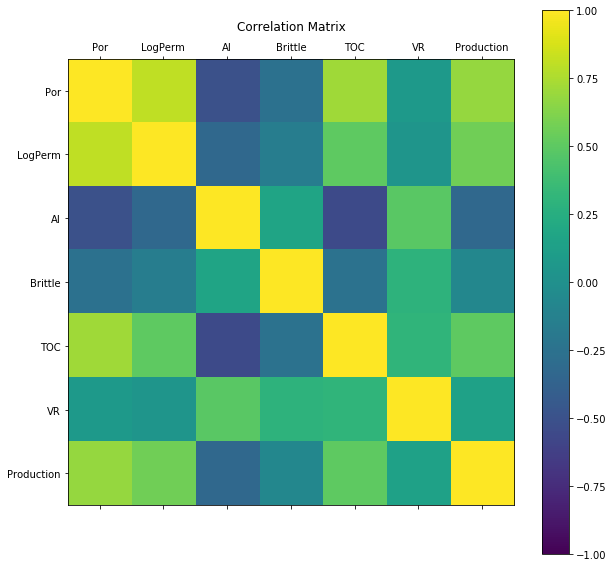

In [9]:
plot_corr(my_data,10)                                      # using our correlation matrix visualization function
plt.show()

This looks good.  There is a mix of correlation magnitudes. Of course, correlation coeffficients are limited to degree of linear correlations.  For more complete information, let's look at the matrix scatter plot from the Pandas package. 

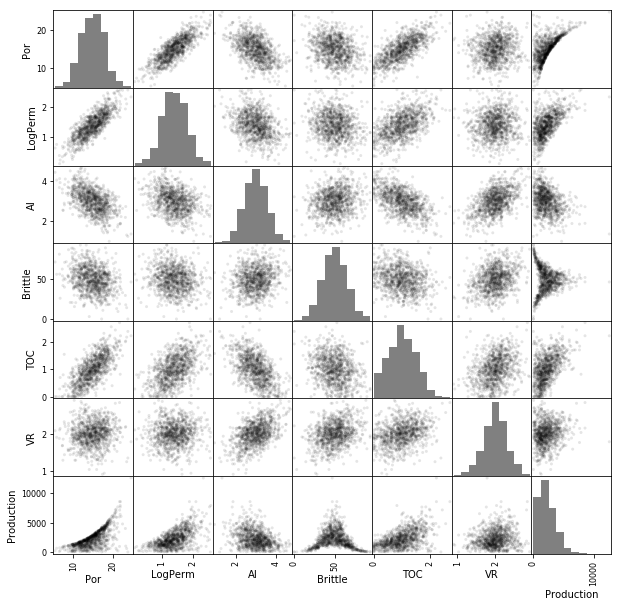

In [10]:
pd_plot.scatter_matrix(my_data, alpha = 0.1,              # pandas matrix scatter plot
    figsize=(10, 10),color = 'black', hist_kwds={'color':['grey']})
plt.show()

#### Working with Only Two Features

Let's simplify the problem to 2 feature), Porosity and Brittleness to predict Production rate.  We will also reduce the number of wells from 1,000 to 500.  By working with only 2 features, it is very easy to visualize the segmentation of the feature space (it is only 2D and can be shown compleltely on a single plot).

In [11]:
my_data_por_perm = my_data.iloc[0:500,[0,3,6]]            # extract just por, brittle and prod with 100 samples
my_data_por_perm.describe().transpose()                   # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,500.0,14.899360,2.985967,5.400000,12.850000,14.900000,17.012500,23.850000
Brittle,500.0,49.746820,15.212123,0.000000,39.312500,49.595000,59.207500,93.470000
Production,500.0,2203.936528,1392.003509,2.713535,1194.793253,1972.314641,2949.902179,8554.267033


Let's first check the univariate statistics of Porosity, Brittleness and Producton.

3.0 8554.0


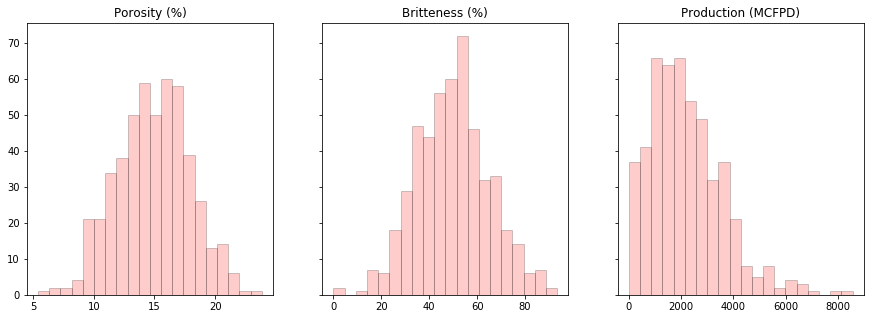

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(15,5))
ax1.hist(my_data_por_perm["Por"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
ax1.set_title('Porosity (%)')
ax2.hist(my_data_por_perm["Brittle"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
ax2.set_title('Britteness (%)')
ax3.hist(my_data_por_perm["Production"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
ax3.set_title('Production (MCFPD)')
prod_min = round(min(my_data_por_perm["Production"]),0); prod_max = round(max(my_data_por_perm["Production"]),0)
print(prod_min,prod_max)
plt.show()

The distributions are well behaved, we cannot observe obvious gaps nor truncations.  Let's look at a scatter plot of Porosity vs. Brittleness with points colored by Production.

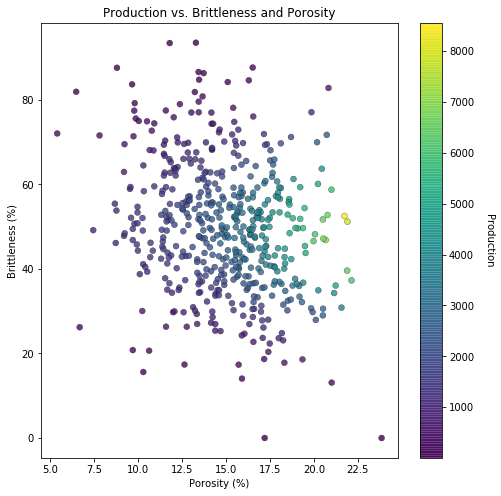

In [13]:
plt.figure(figsize=(8,8))
im = plt.scatter(my_data_por_perm["Por"],my_data_por_perm["Brittle"],s=None, c=my_data_por_perm["Production"], marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Production vs. Brittleness and Porosity'); plt.xlabel('Porosity (%)'); plt.ylabel('Brittleness (%)')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production", rotation=270, labelpad=20)
plt.show()

This problem looks complicated and could not be modeled with simple linear regression.  It appears there is a sweet spot for Brittleness and increasing Porosity is always beneficial for Production.

#### Calculation of Decision Tree

The input for the decision tree is 2 DataFrames, one with the predictors / features and the other with the response variable.  We will use the DataFrame member function copy() to copy the respective columns to 2 new DataFrames.  


In [14]:
features = my_data_por_perm[['Por','Brittle']].copy()     # make a new DataFrame with features
response = my_data_por_perm[['Production']].copy()        # make a new DataFrame with responses

Now we are ready to run the DecisionTreeRegressor command to build our regression tree for Production given Porosity and Brittleness.  We will use our two functions defined above to visualize the decision tree prediction over the feature space and the cross plot of actual and estimated production for the training data along with three model metrics from the sklearn.metric module.

Note, we constrain our tree by limitting it to a maximum depth of 3, only 3 levels of hierarchical spilts and a minimum of 5 data at each terminal node / leaf.

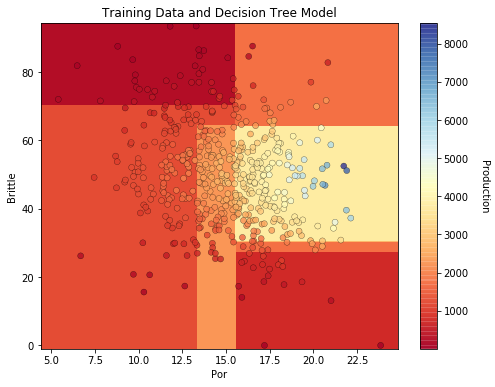

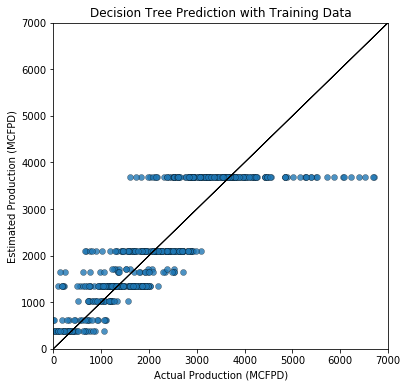

Mean Squared Error on Training =  593556.2 , Varianace Explained = 0.69 Cor = 0.83


In [15]:
my_tree = tree.DecisionTreeRegressor(min_samples_leaf=5, max_depth = 3)
my_tree = my_tree.fit(features, response)

visualize_tree(my_tree,my_data_por_perm["Por"],my_data_por_perm["Brittle"],my_data_por_perm["Production"],'Training Data and Decision Tree Model')

check_tree(my_tree,my_data_por_perm["Por"],my_data_por_perm["Brittle"],my_data_por_perm["Production"],'Decision Tree Prediction with Training Data')

See the horizontal lines on the plot of estimated vs. actual production (plot on the bottom)? That is expected as the regression tree estimates with the average of the data in each region of the feature space (terminal node). It looks like 8 terminal nodes / regions in the feature space (2 are almost on top of each other), we can confirm that below when we look at the tree.  In other words, the model solution is binned and has only 8 possible predictions. If we have a more complicated tree with more terminal nodes then there would be more lines.  

As reported above, we described 85% of the variance with this simple tree. The visualization of the estimates over the entire feature space demonstrate the hierarchical binary splitting applied in a decision tree (the plot on the top).

It is useful and instructive to visualize the tree.  There is a nice tree visualizer in the sklearn.tree known as export_graphviz.  Check out the result below.  

In [18]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(my_tree, out_file=dot_data,feature_names = list(features),  
                filled=True, rounded=True,leaves_parallel = False, impurity = True,
                special_characters=False, node_ids = True, proportion = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

ModuleNotFoundError: No module named 'pydotplus'

We can confirm that we a miximum of 3 levels and that we have 8 terminal nodes.  Each represents a region in the feature space.  So for any combination of Porosity and Brittleness we can predict Production with our tree.  All we have to do is start at node 0 at the top and track each decision, go left if true and go right if false.  When we get to a terminal node we have a prediction for production.  Of course, we could trim or "prune" the tree to simplify it.  For example, we could cut off all the terminal nodes and work with a maximum tree depth of 2 (a tree with only up to 2 levels).  The prediction if the tree was pruned to make each node a terminal node is indicated.

Next let's increase the complexity of our tree and check out the change in variance explained with increased complexity.  We will first do this by constraining the maximum number of terminal nodes ("max_leaf_nodes"), without any constraint on number of data in terminal nodes ("min_samples_leaf").  You could try constraining the minimum number of data at the terminal nodes.  That will further limit tree growth and your tree may not reach the target number of terminal nodes. 


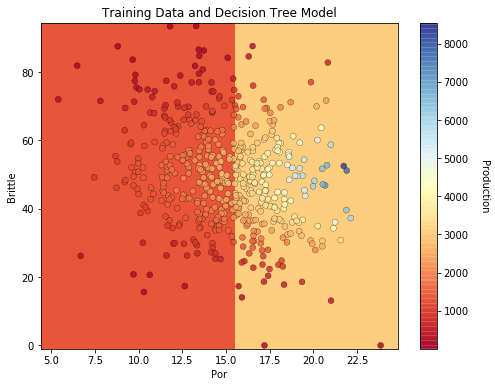

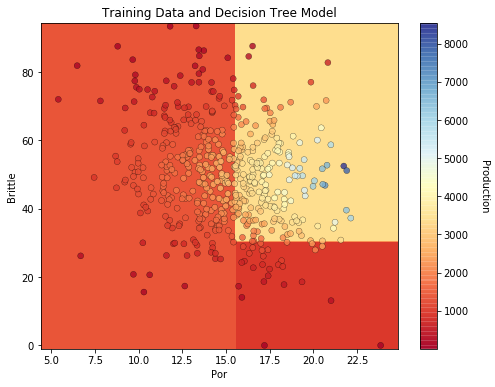

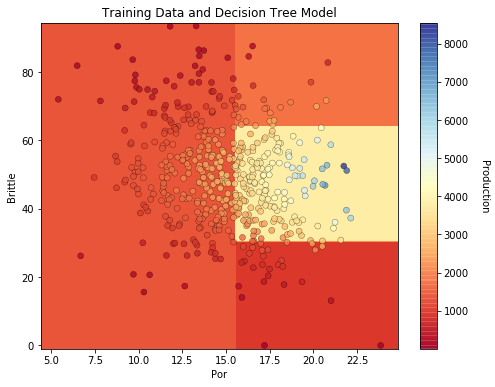

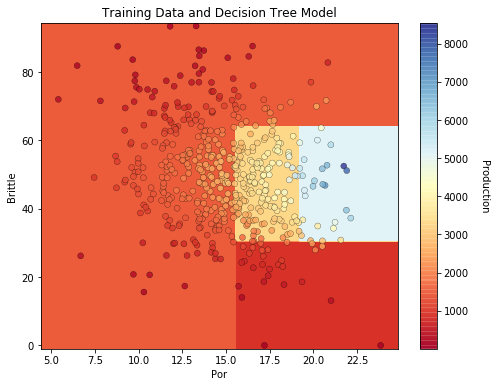

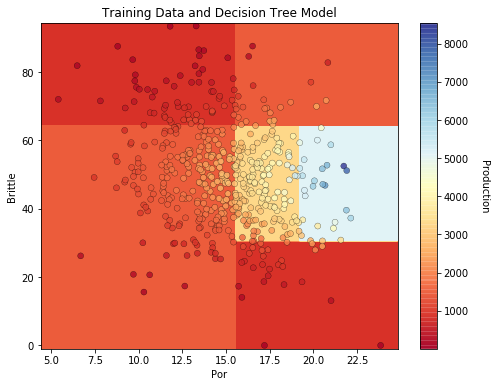

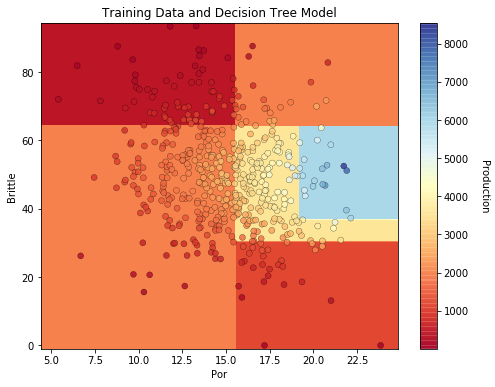

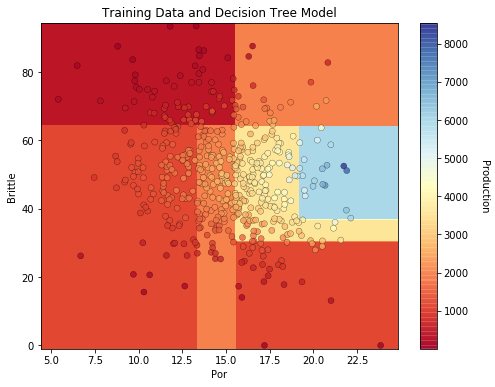

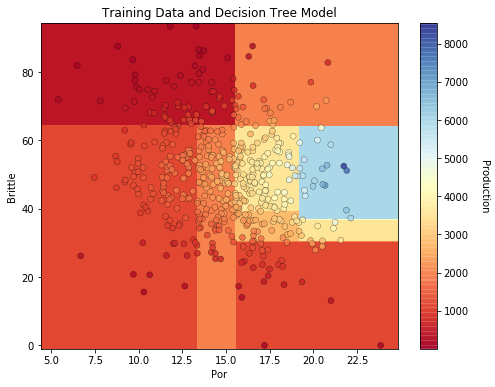

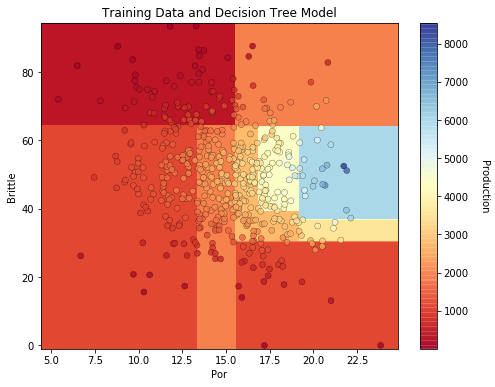

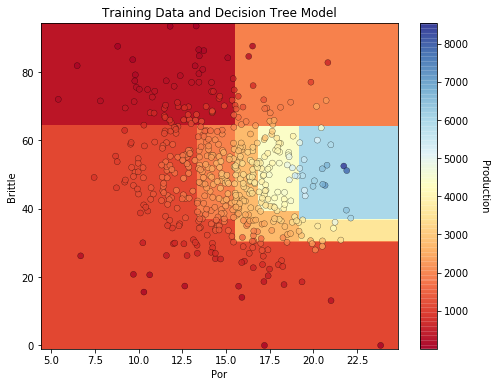

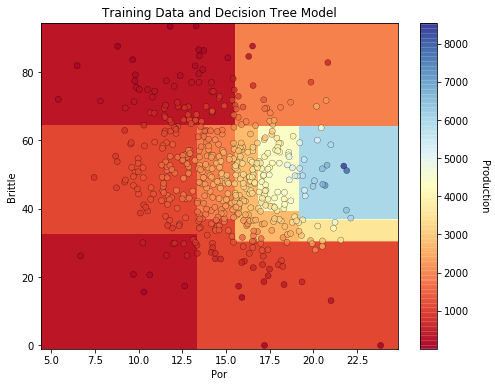

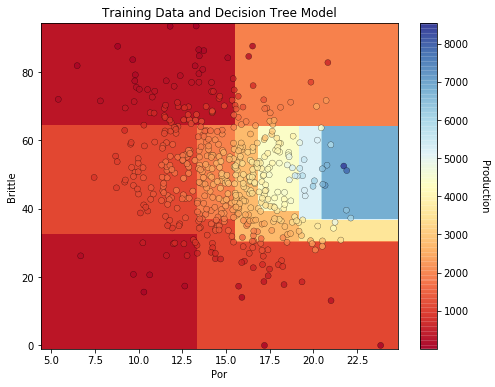

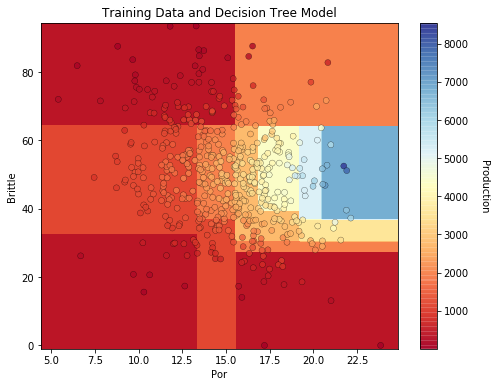

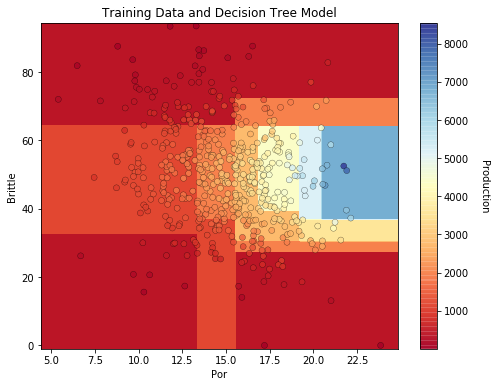

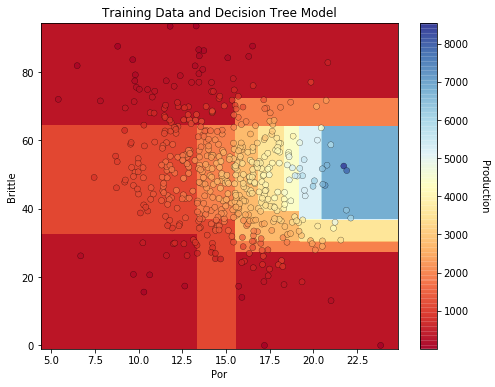

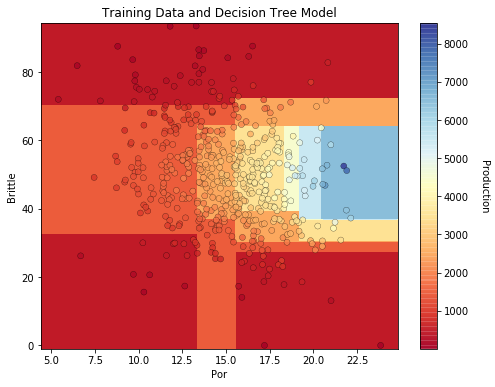

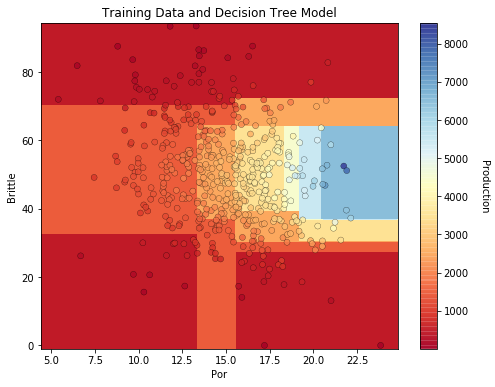

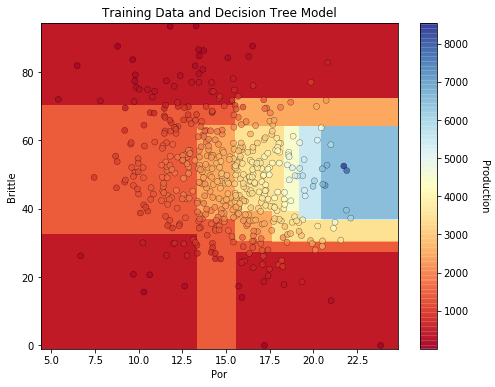

In [19]:
trees = []
error = []
var_exp = [] 
nodes = []

inodes = 2
while inodes < 20:
    my_tree = tree.DecisionTreeRegressor(min_samples_leaf=1,max_leaf_nodes=inodes)
    my_tree = my_tree.fit(features, response)
    trees.append(my_tree)
    visualize_tree(my_tree,my_data_por_perm["Por"],my_data_por_perm["Brittle"],my_data_por_perm["Production"],'Training Data and Decision Tree Model')

    predict_train = my_tree.predict(np.c_[my_data_por_perm["Por"],my_data_por_perm["Brittle"]])
    
    error.append(metrics.mean_squared_error(my_data_por_perm["Production"],predict_train))
    var_exp.append(metrics.explained_variance_score(my_data_por_perm["Production"],predict_train))    

    all_nodes = my_tree.tree_.node_count             
    decision_nodes = len([x for x in my_tree.tree_.feature if x != _tree.TREE_UNDEFINED]) 
    terminal_nodes = all_nodes - decision_nodes
    nodes.append(terminal_nodes)
    
    inodes+=1

Let's see how our set of tree models form simple to complicated (with terminal nodes from 3 to 20) performed with an  accuracy measured as mean square error for the training data.

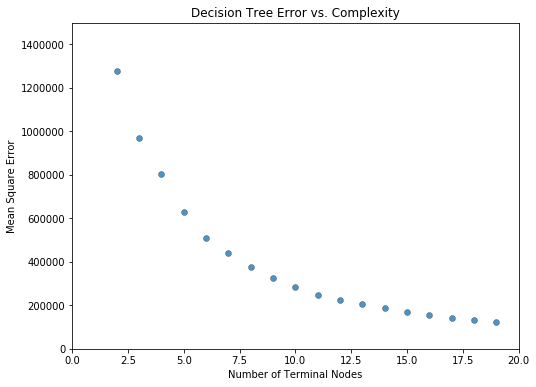

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(nodes,error,s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Decision Tree Error vs. Complexity'); plt.xlabel('Number of Terminal Nodes'); plt.ylabel('Mean Square Error')
plt.xlim(0,20); plt.ylim(0,1500000)
plt.show()

It is useful to evaluate the performance of our tree by observing the accuracy vs. complexity trade-off.  Also, it was useful for us to observed the tree model over the feature space as we incrementally add terminal nodes. We can graphically observe the hierarical binary splitting quite clearly.  

Yet, what we really want to do is test our model performance.  We should perform cross validation that does not use the same data to train and to test the model.  sklearn has a built in cross validation method called cross_val_score that we can use to:

1. Apply k-fold approach with iterative separation of training and testing data
2. Automate the model construction, looping over folds and averaging the metric of interest

Let's try it out on our trees with variable number of terminal nodes.  Note the cross validation is set to use 4 processors, but still will likely take a couple of minutes to run.


In [21]:
score = []                     # code from StackOverFlow by Dimosthenis
node = []
for inodes in range(2,30):
    my_tree = tree.DecisionTreeRegressor(max_leaf_nodes=inodes) 
    scores = cross_val_score(estimator=my_tree, X= np.c_[my_data['Por'],my_data['Brittle']],y=my_data['Production'], cv=2, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
    score.append(abs(scores.mean()))
    node.append(inodes)

The output is an array of average scores (MSE) over the k-folds for each level of complexity (number of terminal nodes) and the maximum number of terminal nodes parameter in another array.

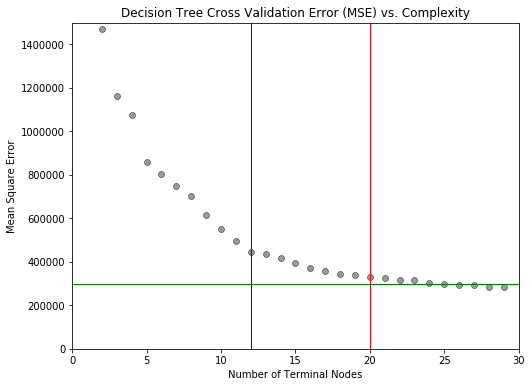

In [22]:
plt.figure(figsize=(8,6))
plt.arrow(20,0,0,1500000,width=0.02,color='red',head_length=0.0,head_width=0.0)
plt.arrow(12,0,0,1500000,width=0.02,color='blue',head_length=0.0,head_width=0.0)
plt.arrow(0,300000,90,0,width=0.02,color='green',head_length=0.0,head_width=0.0)
plt.scatter(node,score,s=None, c="grey", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.5, verts=None, edgecolors="black")
plt.title('Decision Tree Cross Validation Error (MSE) vs. Complexity'); plt.xlabel('Number of Terminal Nodes'); plt.ylabel('Mean Square Error')
plt.xlim(0,30); plt.ylim(0,1500000)
plt.show()

It is clear that at about 20 terminal nodes the increase in accuracy with increase in complexity is quite low.  One could select the 20 as the maximum number of terminal node parameter for the tree.  Also, there is an inflection point at about 12 terminal nodes, if the accuracy is sufficent, one could select 12. In addition, there might be required level of accuracy as represented by the green line and we could choose the minimum number of terminal nodes to reach that accuracy.  Let's limit our tree to 12 terminal nodes and visualize it.  

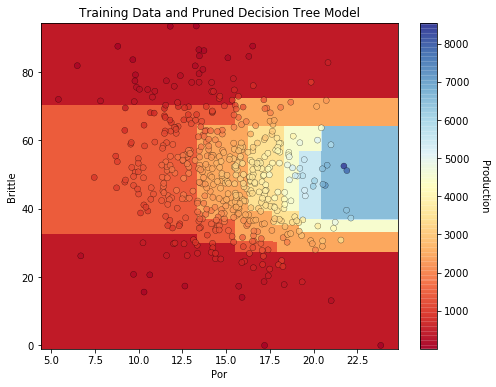

In [433]:
my_pruned_tree = tree.DecisionTreeRegressor(min_samples_leaf=1,max_leaf_nodes=12)
my_pruned_tree = my_tree.fit(features, response)

visualize_tree(my_tree,my_data_por_perm["Por"],my_data_por_perm["Brittle"],my_data_por_perm["Production"],'Training Data and Pruned Decision Tree Model')

Let's cover a couple more interesting topics. 

#### Interogating Decision Trees

It may be useful to evaluate for any possible feature combination, the order of decision nodes that resulted in the specific prediction.  The following function provides the list of nodes and decision 1 is $\le$ and 0 is $\gt$. We start at node 0 and traverse the series of splits to reach the prediction.

In [274]:
decision_path = my_pruned_tree.decision_path(np.c_[10.0,30.0])
print(decision_path)

  (0, 0)	1
  (0, 1)	1
  (0, 7)	1
  (0, 9)	1
  (0, 19)	1


Furthermore it may be useful to convert the decision tree to code, a nested set of if statements.  This creates a portable model that could be copied and applied as a standalone function.  Also, one could conveniently interogate the code version of the tree.  We use the previously defined function to do this with our pruned tree.

In [435]:
tree_to_code(my_pruned_tree, list(features))

def tree(Por, Brittle):
  if Por <= 15.524999618530273:
    if Brittle <= 64.27000427246094:
      if Por <= 13.364999771118164:
        if Brittle <= 32.63999938964844:
          return [[ 543.0756475]]
        elif Brittle > 32.63999938964844
          if Por <= 12.420000076293945:
            return [[ 1351.96685952]]
          elif Por > 12.420000076293945
            return [[ 1891.10389152]]
      elif Por > 13.364999771118164
        if Brittle <= 37.05000305175781:
          if Brittle <= 30.059999465942383:
            return [[ 806.66082248]]
          elif Brittle > 30.059999465942383
            return [[ 1509.62890265]]
        elif Brittle > 37.05000305175781
          if Por <= 14.154999732971191:
            return [[ 2053.49758146]]
          elif Por > 14.154999732971191
            if Brittle <= 40.599998474121094:
              return [[ 2107.50022863]]
            elif Brittle > 40.599998474121094
              return [[ 2563.08473605]]
    elif Brittle > 64.270004

Let's check the Gini importance measure.  This is normalized, total reduction mean squared error due to inclusion of the variable.

In [397]:
print('Por Importance =', round(my_pruned_tree.feature_importances_[0],2),'Brittle Importance =', round(my_tree.feature_importances_[1],2))

Por Importance = 0.54 Brittle Importance = 0.46


Let's take a last look at the graphical representation of our pruned tree.  

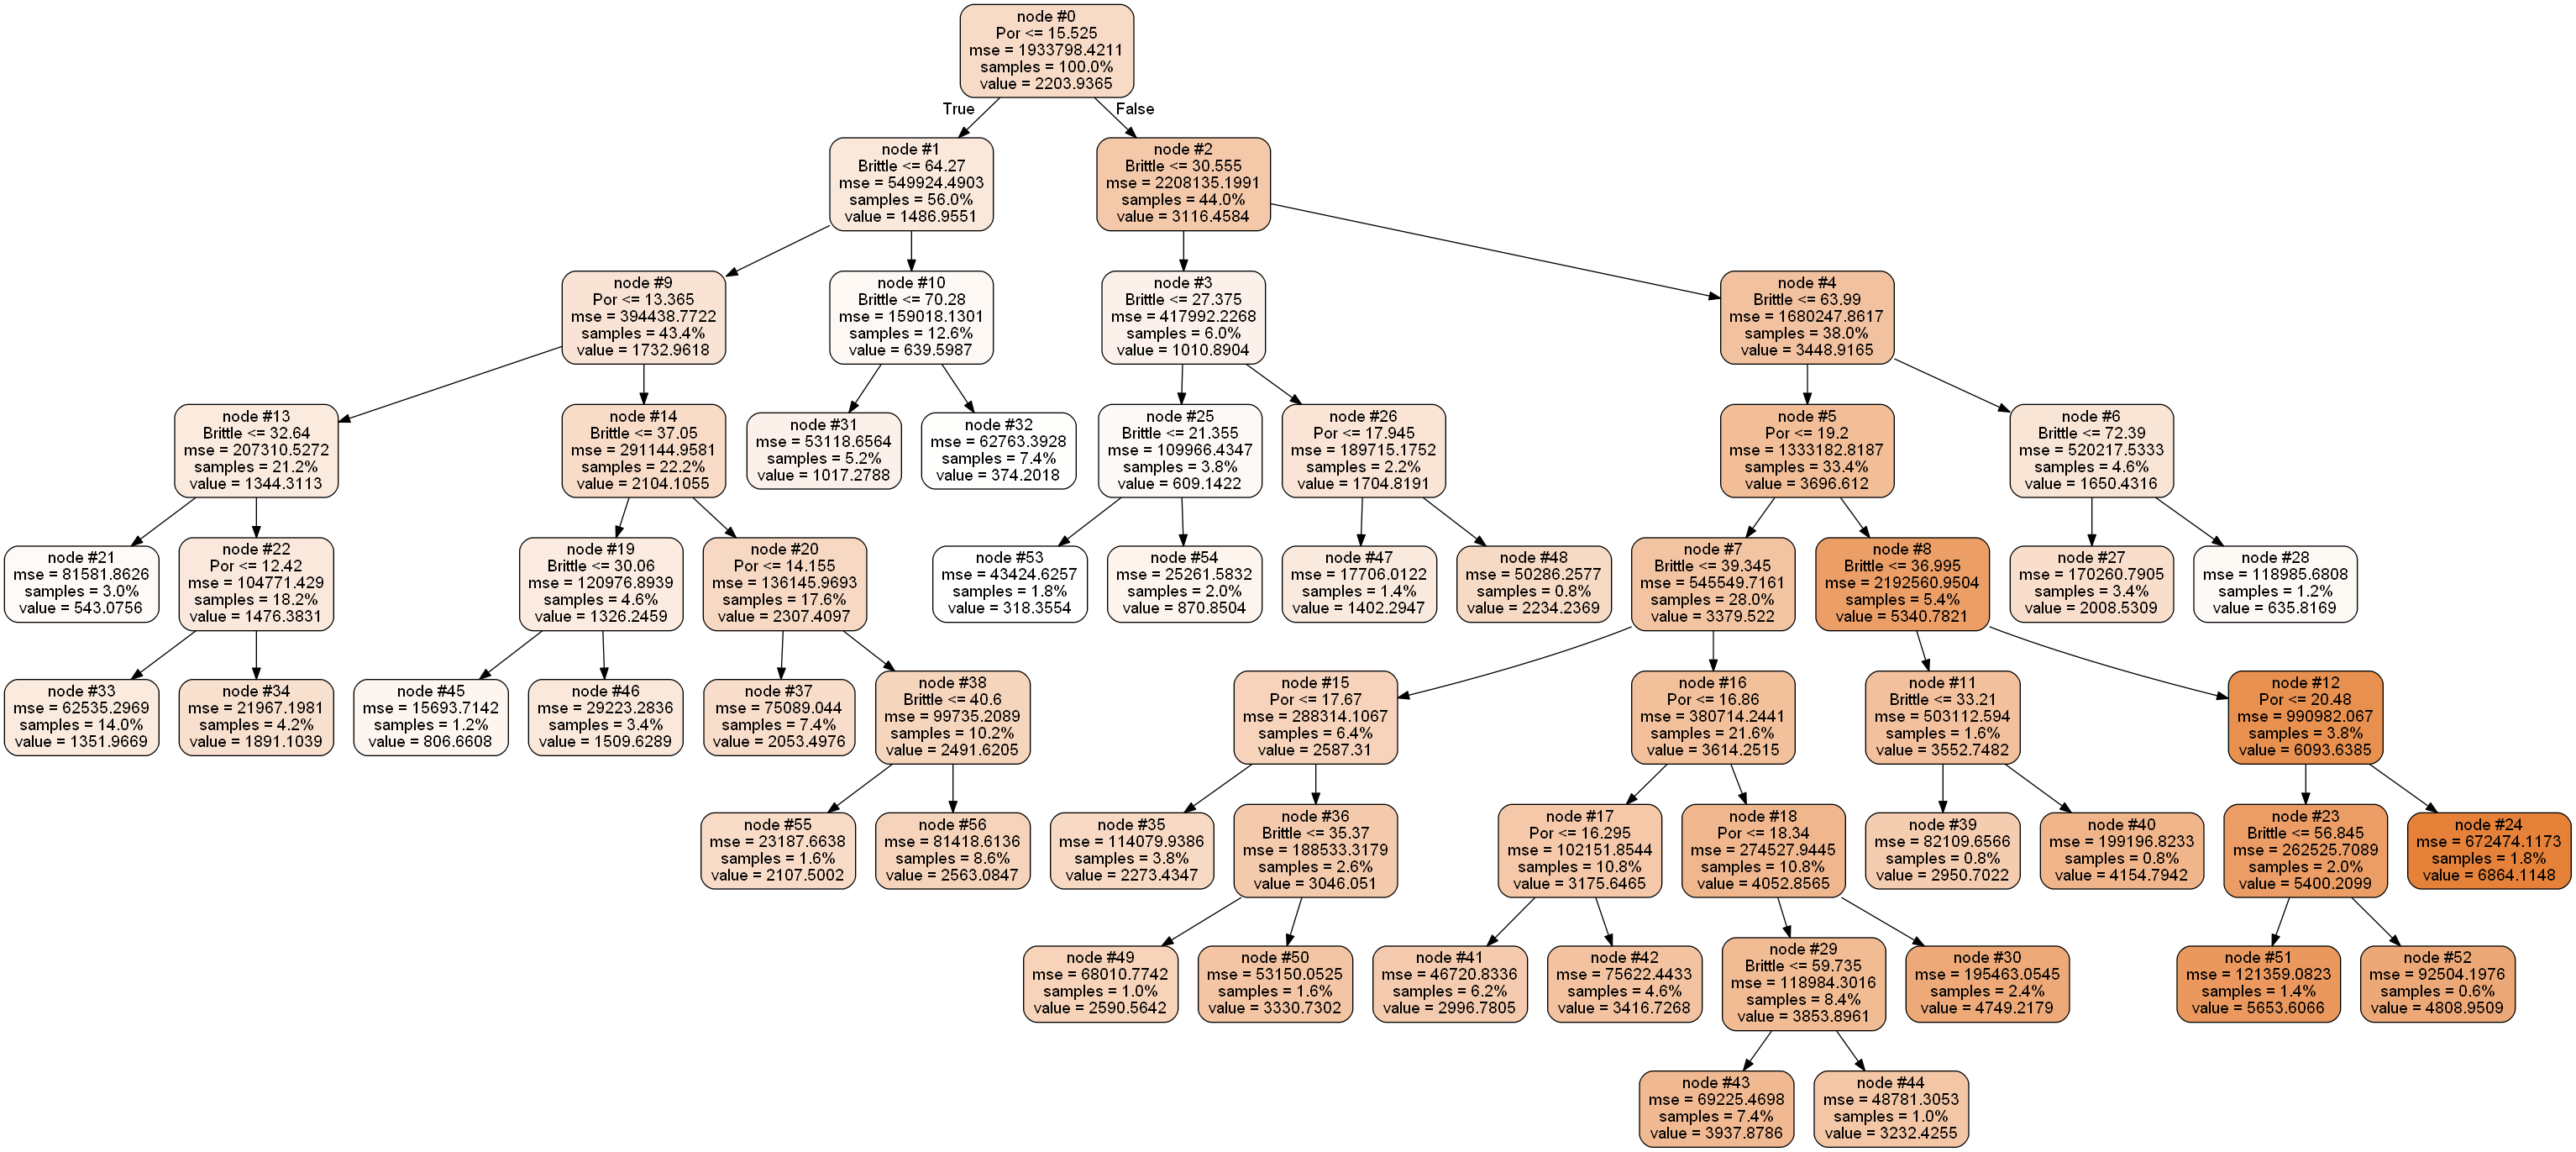

In [399]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(my_pruned_tree, out_file=dot_data,feature_names = list(features),  
                filled=True, rounded=True,leaves_parallel = False, impurity = True,
                special_characters=False, node_ids = True, proportion = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


There are so many more exercised and tests that one could attempt to gain experience with decison trees. I'll end here for brevity, but I invite you to continue. Consider, on your own apply other data sets or attempting modeling with random forest and boosting.  I hope you found this tutorial useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
On twitter I'm the @GeostatsGuy.